In [1]:
import pandas as pd
import json
from decimal import Decimal
import math
import matplotlib.pyplot as plt
import numpy as np

# Load datasets
token_price = pd.read_csv('/home/user/gzhao/Thesis/Price/token_price.csv')
Uniswap_v2_df = pd.read_csv('/local/scratch/exported/MP_Defi_txs_TY_23/guanda/Uniswap_v2_ABC.csv')
Uniswap_v3_df = pd.read_csv('/local/scratch/exported/MP_Defi_txs_TY_23/guanda/Uniswap_v3_ABC.csv')
Aave_v2_df = pd.read_csv('/local/scratch/exported/MP_Defi_txs_TY_23/guanda/Aave_v2_ABC.csv')
Aave_v3_df = pd.read_csv('/local/scratch/exported/MP_Defi_txs_TY_23/guanda/Aave_v3_ABC.csv')
Balancer_v2_df = pd.read_csv('/local/scratch/exported/MP_Defi_txs_TY_23/guanda/Balancer_v2_ABC.csv')

# Assign platform names
Uniswap_v2_df['platform'] = 'Uniswap v2'
Uniswap_v3_df['platform'] = 'Uniswap v3'
Aave_v2_df['platform'] = 'Aave v2'
Aave_v3_df['platform'] = 'Aave v3'
Balancer_v2_df['platform'] = 'Balancer v2'

# Merge all datasets
merged_flashloan_df = pd.concat([Uniswap_v2_df, Uniswap_v3_df, Aave_v2_df, Aave_v3_df, Balancer_v2_df], ignore_index=True)

In [2]:
# Convert token_price IDs into a set for faster lookup
token_price_set = set(token_price['token.id'])

# Step 1: Remove transactions where highest_profit_address is a token
filtered_df = merged_flashloan_df[~merged_flashloan_df['highest_profit_address'].isin(token_price_set)]

In [3]:
# Function to convert price_list safely
def convert_price_list(price_list_str):
    try:
        price_list_str = price_list_str.replace("Decimal(", "").replace(")", "")
        return json.loads(price_list_str.replace("'", '"'))  # Convert to JSON-compatible format
    except:
        return []

# Convert price_list column
filtered_df['price_list'] = filtered_df['price_list'].map(convert_price_list)

# Step 2: Remove transactions where `price_list` contains NaN
def price_list_contains_nan(price_list):
    """Check if any value in the price_list is NaN, if so, remove the transaction."""
    if not isinstance(price_list, list):
        return True  # Remove if it's not a valid list
    return any(math.isnan(float(entry.get('price', float('nan')))) for entry in price_list if isinstance(entry, dict) and 'price' in entry)

filtered_df = filtered_df[~filtered_df['price_list'].apply(price_list_contains_nan)]

/tmp/ipykernel_3148252/2459897660.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['price_list'] = filtered_df['price_list'].map(convert_price_list)


In [4]:
# Step 3: Test different `highest_profit_in_usd` thresholds and store counts
thresholds = list(range(1000, 100000, 1000)) 
transaction_counts = []

for threshold in thresholds:
    count = filtered_df[filtered_df['highest_profit_in_usd'] > threshold].shape[0]
    transaction_counts.append(count)

threshold_data = pd.DataFrame({'threshold': thresholds, 'transaction_count': transaction_counts})
threshold_data.to_csv('/local/scratch/exported/MP_Defi_txs_TY_23/guanda/heuristic_threshold_analysis.csv', index=False)

# Step 4: Compute First-Order and Second-Order Derivatives
first_derivative = np.gradient(transaction_counts, thresholds)  # Rate of change
second_derivative = np.gradient(first_derivative, thresholds)  # Curvature

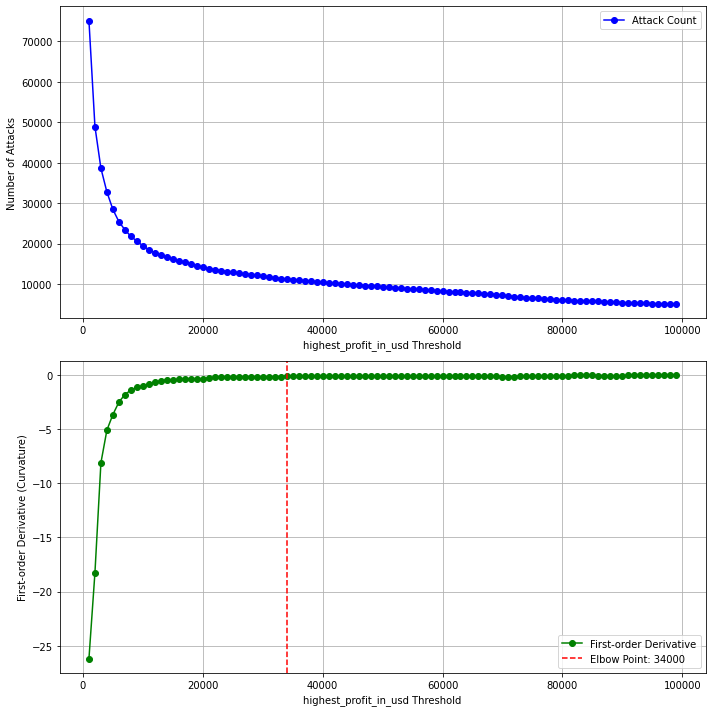

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Step 5: Find the Elbow Point
elbow_threshold = 34000

# Plot Attack Count vs Threshold
ax1.plot(thresholds, transaction_counts, marker='o', linestyle='-', color='b', label="Attack Count")
ax1.set_xlabel('highest_profit_in_usd Threshold')
ax1.set_ylabel('Number of Attacks')
ax1.legend()
ax1.grid(True)

# Plot First-Order Derivative vs Threshold
ax2.plot(thresholds, first_derivative, marker='o', linestyle='-', color='green', label="First-order Derivative")
ax2.axvline(x=elbow_threshold, color='r', linestyle='--', label=f"Elbow Point: {elbow_threshold}")
ax2.set_xlabel('highest_profit_in_usd Threshold')
ax2.set_ylabel('First-order Derivative (Curvature)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [6]:
# Step 9: Filter transactions with highest_profit_in_usd > elbow threshold
filtered_df = filtered_df[filtered_df['highest_profit_in_usd'] > elbow_threshold]

# Attack transaction hashes from external sources
attack_label_list = filtered_df['tx_hash'].tolist()

# Additional attack transaction hashes from external reports
external_attack_hashes = [
    # https://www.immunebytes.com/blog/list-of-flash-loan-attacks-in-crypto/
    "0x3b19e152943f31fe0830b67315ddc89be9a066dc89174256e17bc8c2d35b5af8",
    "0xcb0ad9da33ecabf75df0a24aabf8a4517e4a7c5b1b2f11fee3b6a1ad9299a282",
    "0xcb58fb952914896b35d909136b9f719b71fc8bc60b59853459fc2476d4369c3a",
    "0xf72f1d10fc6923f87279ce6c0aef46e372c6652a696f280b0465a301a92f2e26",
    "0x118b7b7c11f9e9bd630ea84ef267b183b34021b667f4a3061f048207d266437a",

    # https://arxiv.org/abs/2206.10708
    "0x3503253131644dd9f52802d071de74e456570374d586ddd640159cf6fb9b8ad8",
    "0x35f8d2f572fceaac9288e5d462117850ef2694786992a8c3f6d02612277b0877",
    "0x0fc6d2ca064fc841bc9b1c1fad1fbb97bcea5c9a1b2b66ef837f1227e06519a6",
    "0x958236266991bc3fe3b77feaacea120f172c0708ad01c7a715b255f218f9313c",
    "0x46a03488247425f845e444b9c10b52ba3c14927c687d38287c0faddc7471150a",
    "0x8bb8dc5c7c830bac85fa48acad2505e9300a91c3ff239c9517d0cae33b595090",
    "0xf6022012b73770e7e2177129e648980a82aab555f9ac88b8a9cda3ec44b30779",
    "0xcd314668aaa9bbfebaf1a0bd2b6553d01dd58899c508d4729fa7311dc5d33ad7"
]

# Merge attack hash lists
attack_label_list.extend(external_attack_hashes)
attack_label_set = set(attack_label_list)  # Convert to set for fast lookup

# Filter transactions into attack and unlabeled groups
attack_label = merged_flashloan_df[merged_flashloan_df['tx_hash'].isin(attack_label_set)]
unlabeled = merged_flashloan_df[~merged_flashloan_df['tx_hash'].isin(attack_label_set)]

# Save to CSV
unlabeled.to_csv('/local/scratch/exported/MP_Defi_txs_TY_23/guanda/unlabeled.csv', index=False)
attack_label.to_csv('/local/scratch/exported/MP_Defi_txs_TY_23/guanda/attack_label.csv', index=False)